In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import timedelta
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
tweets_data = pd.read_csv('/content/drive/MyDrive/TWITTER DATA SET.csv')

In [77]:
tweets_data['created_at'] = pd.to_datetime(tweets_data['created_at'])

tweets_data['hour'] = tweets_data['created_at'].dt.floor('H')

tweet_frequency = tweets_data.groupby('hour').size().reset_index(name='tweet_count')

tweet_frequency.head()

hour  tweet_count
0 2020-03-27 12:00:00+00:00            3
1 2020-03-27 13:00:00+00:00           33
2 2020-03-27 14:00:00+00:00           21
3 2020-03-27 15:00:00+00:00           16
4 2020-03-27 16:00:00+00:00           19

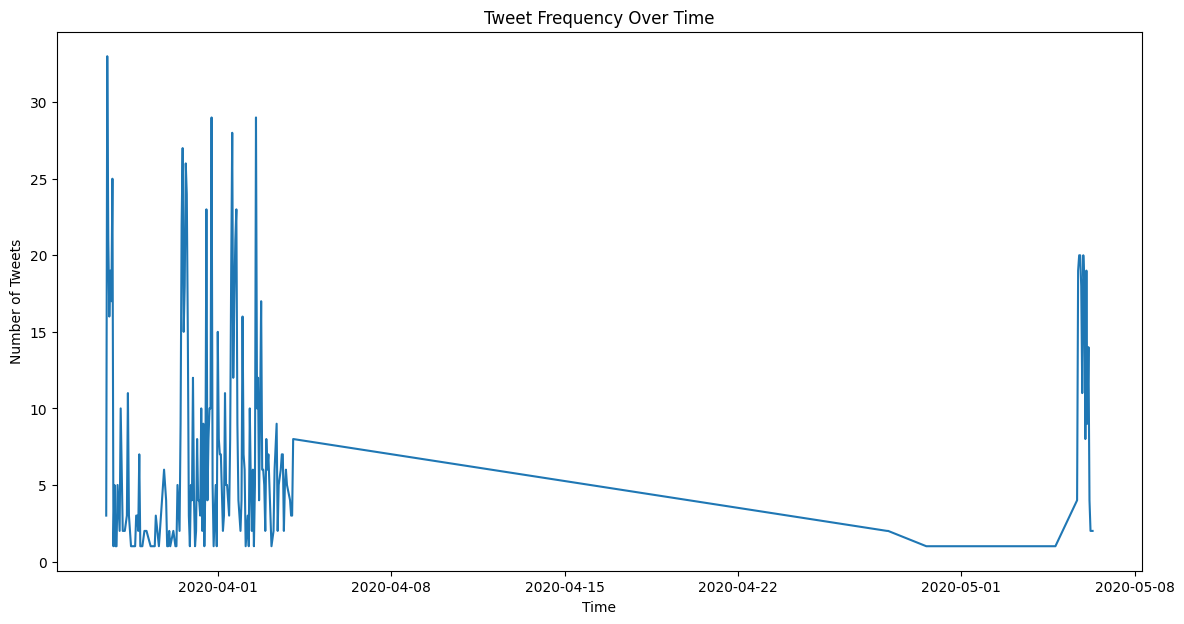

In [78]:
plt.figure(figsize=(14, 7))
plt.plot(tweet_frequency['hour'], tweet_frequency['tweet_count'])
plt.title('Tweet Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.show()

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tweet_frequency['tweet_count'].values.reshape(-1, 1))

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 24

X, Y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
Y_train, Y_test = Y[:training_size], Y[training_size:]

In [104]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])


Epoch 1/100
4/4 [==============================] - 12s 743ms/step - loss: 0.0733 - val_loss: 0.0533
Epoch 2/100
4/4 [==============================] - 1s 169ms/step - loss: 0.0505 - val_loss: 0.0672
Epoch 3/100
4/4 [==============================] - 1s 182ms/step - loss: 0.0578 - val_loss: 0.0522
Epoch 4/100
4/4 [==============================] - 1s 174ms/step - loss: 0.0485 - val_loss: 0.0494
Epoch 5/100
4/4 [==============================] - 1s 167ms/step - loss: 0.0488 - val_loss: 0.0489
Epoch 6/100
4/4 [==============================] - 1s 174ms/step - loss: 0.0476 - val_loss: 0.0492
Epoch 7/100
4/4 [==============================] - 1s 189ms/step - loss: 0.0476 - val_loss: 0.0489
Epoch 8/100
4/4 [==============================] - 1s 295ms/step - loss: 0.0486 - val_loss: 0.0487
Epoch 9/100
4/4 [==============================] - 1s 303ms/step - loss: 0.0481 - val_loss: 0.0482
Epoch 10/100
4/4 [==============================] - 1s 315ms/step - loss: 0.0486 - val_loss: 0.0482
Epoch 11

In [105]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

1/1 [==============================] - 0s 58ms/step


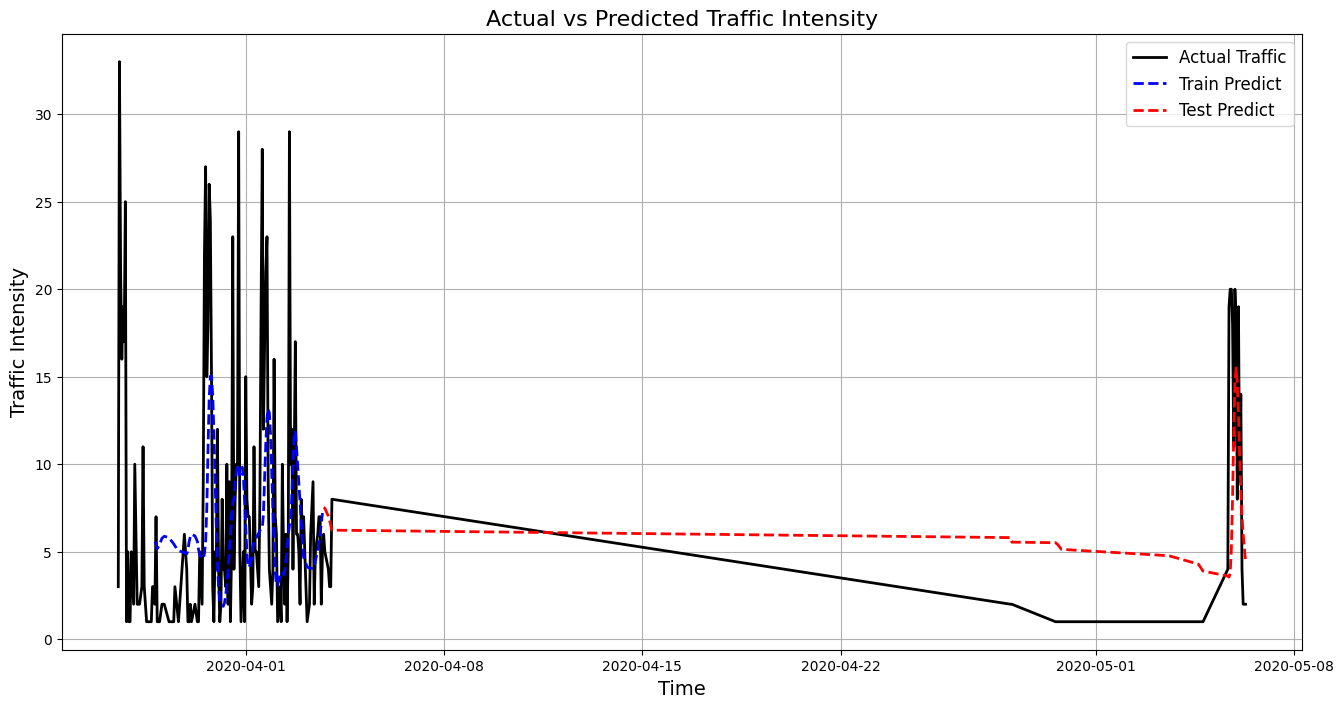

In [106]:
plt.figure(figsize=(16, 8))

plt.plot(tweet_frequency['hour'], tweet_frequency['tweet_count'], label='Actual Traffic', color='black', linewidth=2)

plt.plot(tweet_frequency['hour'][time_step+1:len(train_predict)+time_step+1], train_predict,
         label='Train Predict', color='blue', linestyle='--', linewidth=2)

plt.plot(tweet_frequency['hour'][len(train_predict)+time_step+1:], test_predict,
         label='Test Predict', color='red', linestyle='--', linewidth=2)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Traffic Intensity', fontsize=14)
plt.title('Actual vs Predicted Traffic Intensity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [107]:
train_r2 = r2_score(tweet_frequency['tweet_count'][time_step+1:len(train_predict)+time_step+1], train_predict)
train_mse = mean_squared_error(tweet_frequency['tweet_count'][time_step+1:len(train_predict)+time_step+1], train_predict)


test_r2 = r2_score(tweet_frequency['tweet_count'][len(train_predict)+time_step+1:], test_predict)
test_mse = mean_squared_error(tweet_frequency['tweet_count'][len(train_predict)+time_step+1:], test_predict)


print(f"Training R²: {train_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Training R²: 0.1180
Training MSE: 42.8857
Testing R²: 0.2167
Testing MSE: 39.1888


1/1 [==============================] - 0s 39ms/step


<ipython-input-109-a3e344e07e8c>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_input[0, -1, 0] = prediction


1/1 [==============================] - 0s 35ms/step


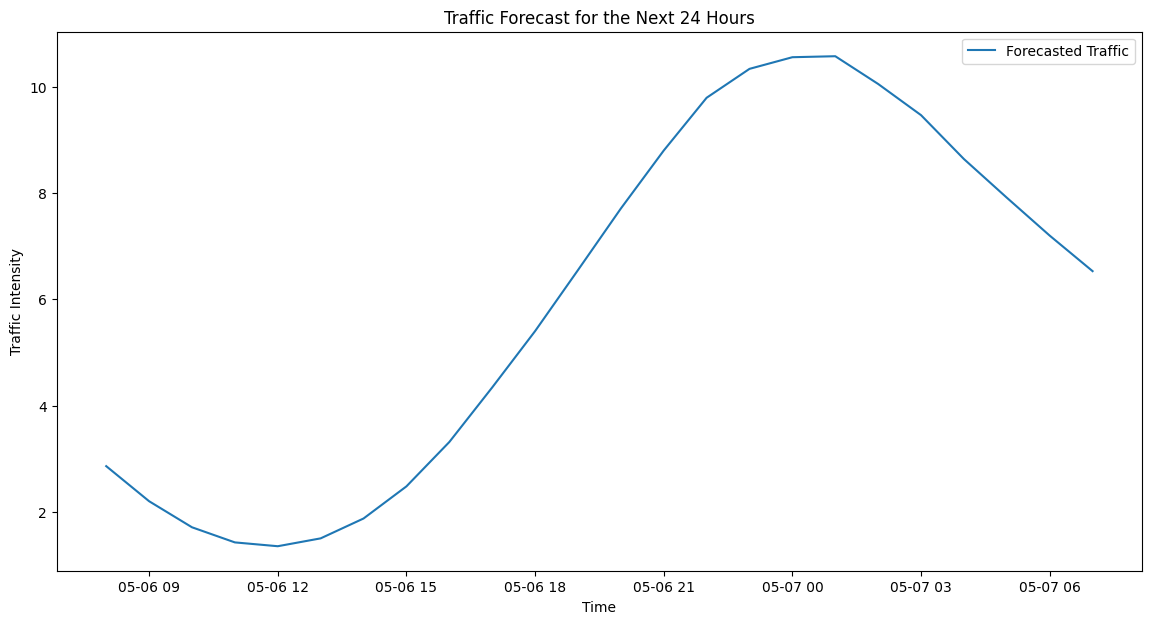

In [109]:
last_hours = scaled_data[-time_step:]
forecast_input = last_hours.reshape((1, time_step, 1))

forecast_output = []

for _ in range(24):
    prediction = model.predict(forecast_input)
    forecast_output.append(prediction[0, 0])

    forecast_input = np.roll(forecast_input, shift=-1, axis=1)
    forecast_input[0, -1, 0] = prediction

forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

forecast_dates = pd.date_range(tweet_frequency['hour'].iloc[-1] + timedelta(hours=1), periods=24, freq='H')

plt.figure(figsize=(14, 7))
plt.plot(forecast_dates, forecast_output, label='Forecasted Traffic')
plt.xlabel('Time')
plt.ylabel('Traffic Intensity')
plt.title('Traffic Forecast for the Next 24 Hours')
plt.legend()
plt.show()